## Construcción de modelos

In [1]:
import pandas as pd
import seaborn as sns
import torch
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.experimental import enable_iterative_imputer
import numpy as np
from sklearn.metrics import (mean_absolute_error, r2_score,
                             root_mean_squared_error, make_scorer,
                             mean_absolute_percentage_error, mean_squared_error)

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from scipy.stats import uniform, randint
from torch.utils.data import TensorDataset, DataLoader
from xgboost import XGBRegressor
import joblib
import os

import sys

sys.path.append('../tp_amq2_17co2024')
from models.used_car_quote_nn import UsedCarQuoteNN
from models.cars_pipeline import CarsPipeline

-------------------
#### Data Processing

-------------------

Apalancados en la ingeniería de features, creamos un conjunto de clases a utilizar en la definición de pipelines, que nos permitan reproducir y modificar con facilidad los pasos de preprocesamiento, previos al entrenamiento de un modelo, incluyendo one shot encoding, imputación iterativa de faltantes y escalado de datos numéricos. 

In [2]:
data = pd.read_csv('../data/raw/Car details v3.csv')

data.drop_duplicates(keep='first', inplace=True)
data["selling_price_log"] = np.log1p(data["selling_price"])

X = data.drop(columns=['selling_price', 'selling_price_log'])
y = data['selling_price']
y_log = data['selling_price_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.3, random_state=42)

In [3]:
final_pipeline = CarsPipeline()

X_train_processed = final_pipeline.fit_transform_df(X_train)
X_test_processed = final_pipeline.transform_df(X_test)

/Users/cbarril/posgrado/materias/aprendizaje_maquinas_I/tp_amq1_17co2024/amq1/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


El warning observado es por marcas con muy pocas observaciones, que no tienen apariciones en el dataset de prueba.
Confirmamos que no quedan datos faltantes:

In [4]:
missing_values = X_train_processed.isnull().sum()

for column, missing in missing_values.items():
    print(f"Feature: {column} - Missing values: {missing}")

X_train_processed

Feature: year - Missing values: 0
Feature: km_driven - Missing values: 0
Feature: owner - Missing values: 0
Feature: seats - Missing values: 0
Feature: mileage_kmpl - Missing values: 0
Feature: engine_cc - Missing values: 0
Feature: max_power_bhp - Missing values: 0
Feature: torque_peak_power - Missing values: 0
Feature: torque_peak_speed - Missing values: 0
Feature: fuel_Diesel - Missing values: 0
Feature: fuel_LPG - Missing values: 0
Feature: fuel_Petrol - Missing values: 0
Feature: seller_type_Individual - Missing values: 0
Feature: seller_type_Trustmark Dealer - Missing values: 0
Feature: transmission_Manual - Missing values: 0
Feature: make_Audi - Missing values: 0
Feature: make_BMW - Missing values: 0
Feature: make_Chevrolet - Missing values: 0
Feature: make_Daewoo - Missing values: 0
Feature: make_Datsun - Missing values: 0
Feature: make_Fiat - Missing values: 0
Feature: make_Force - Missing values: 0
Feature: make_Ford - Missing values: 0
Feature: make_Honda - Missing values: 0

,year,km_driven,owner,seats,mileage_kmpl,engine_cc,max_power_bhp,torque_peak_power,torque_peak_speed,fuel_Diesel,...,make_Mitsubishi,make_Nissan,make_Opel,make_Peugeot,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo
0,0.143297,0.052265,-0.702988,1.577696,-1.615701,3.105192,2.525342,1.502055,0.386272,0.906949,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,4.209293,-0.157947,-0.040656
1,1.122097,-0.920472,-0.702988,-0.441755,0.185294,-0.890608,-0.619772,-0.741781,0.494641,-1.102598,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
2,1.122097,-0.265745,-0.702988,-0.441755,0.705840,-0.089031,0.028663,0.429096,-0.318129,0.906949,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
3,1.122097,-0.920472,-0.702988,-0.441755,1.054420,-0.888594,-0.652648,-0.770093,1.307411,-1.102598,...,-0.045464,-0.096794,-0.014364,-0.014364,5.842126,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
4,-0.590803,0.669578,0.626219,-0.441755,-0.581581,-0.070905,-0.527407,-0.373369,-0.589053,0.906949,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,3.141648,-0.237570,-0.157947,-0.040656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4843,-2.059004,0.295449,0.626219,-0.441755,-1.325218,-0.284390,-0.558717,-0.644160,-0.589053,-1.102598,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
4844,-1.080203,-0.059974,-0.702988,-0.441755,-0.790729,-0.489819,-0.089063,-0.571731,1.578335,-1.102598,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
4845,-0.346103,-0.335969,-0.702988,-0.441755,-0.209763,-0.489819,-0.064015,-0.562714,1.036488,-1.102598,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
4846,1.366797,-1.115991,-0.702988,-0.441755,0.396766,-0.489819,-0.189256,-0.571731,1.253227,-1.102598,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656


In [5]:
X_test_processed

,year,km_driven,owner,seats,mileage_kmpl,engine_cc,max_power_bhp,torque_peak_power,torque_peak_speed,fuel_Diesel,...,make_Mitsubishi,make_Nissan,make_Opel,make_Peugeot,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo
0,-1.080203,3.288483,-0.702988,1.577696,-1.557605,2.122354,0.443211,0.213819,0.386272,0.906949,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,4.209293,-0.157947,-0.040656
1,0.387997,-0.658581,-0.702988,1.577696,-0.813968,1.487940,1.633000,1.384841,-0.263944,0.906949,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
2,1.122097,0.295449,-0.702988,-0.441755,0.812738,0.116398,0.348028,0.257783,0.223718,0.906949,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
3,-1.324903,0.482513,1.955426,-0.441755,-0.511865,-0.763725,-0.746579,-0.829908,0.494641,-1.102598,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
4,1.122097,-0.639875,-0.702988,-0.441755,1.463420,0.116398,0.336756,0.212701,-1.401823,0.906949,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073,-2.793104,0.108384,1.955426,-1.451480,-0.790729,-1.297438,-1.591955,-1.058620,-0.589053,-1.102598,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
2074,1.122097,-0.920472,-0.702988,-0.441755,0.580351,-0.489819,-0.189256,-0.571731,1.253227,-1.102598,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
2075,0.387997,-0.546342,-0.702988,1.577696,-0.235325,0.106328,0.380590,0.483195,-0.859976,0.906949,...,-0.045464,-0.096794,-0.014364,-0.014364,-0.171171,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656
2076,1.122097,-0.901765,-0.702988,-0.441755,0.022624,0.041880,0.645162,0.618442,-1.401823,0.906949,...,-0.045464,-0.096794,-0.014364,-0.014364,5.842126,-0.106132,-0.318304,-0.237570,-0.157947,-0.040656


A continuación crearemos diversos modelos para luego compararlos.

-------------------
#### Ridge

-------------------

Empezaremos con uno simple, Ridge, utilizando grid search para búsqueda del hiper parámetro alpha, con validación cruzada de 5 k-folds.

In [6]:
model_file_path = '../models/best_ridge_model.pkl'

# Verificar si el modelo ya existe
if os.path.exists(model_file_path):
    print(f"El modelo existe. Cargando el modelo desde '{model_file_path}'...")
    ridge_best_model = joblib.load(model_file_path)
    print(f"El mejor valor de alpha es: {ridge_best_model.alpha}")
else:
    # Si no existe, entrenar y guardar el modelo
    print("El modelo no existe. Entrenando un nuevo modelo...")

    ridge = Ridge()
    
    grid_search = GridSearchCV(
        ridge,
        {"alpha": np.linspace(1, 100, 1000)},
        refit=True,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring='neg_mean_absolute_error'
    )
    
    grid_search.fit(X_train_processed, y_train_log)
    
    best_alpha = grid_search.best_params_['alpha']
    print(f"El mejor valor de alpha es: {best_alpha}")
    
    ridge_best_model = grid_search.best_estimator_

    # Guardar el mejor modelo
    joblib.dump(ridge_best_model, model_file_path)
    print(f"Nuevo modelo entrenado y guardado como '{model_file_path}'.")

El modelo existe. Cargando el modelo desde '../models/best_ridge_model.pkl'...
El mejor valor de alpha es: 2.288288288288288


In [7]:
y_pred_ridge_log = ridge_best_model.predict(X_test_processed)
y_pred_ridge = np.expm1(y_pred_ridge_log)

y_pred_ridge_train_log = ridge_best_model.predict(X_train_processed)
y_pred_ridge_train = np.expm1(y_pred_ridge_train_log)

metrics_ridge = {
    "name": "Ridge",
    "MAE_training": mean_absolute_error(y_train, y_pred_ridge_train), #
    "MAE": mean_absolute_error(y_test, y_pred_ridge),
    "RMSE": root_mean_squared_error(y_test, y_pred_ridge),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_ridge),
    "R2": r2_score(y_test, y_pred_ridge)
}
metrics_ridge

{'name': 'Ridge',
 'MAE_training': 95959.08204331702,
 'MAE': 94858.94804066574,
 'RMSE': 190214.86763548112,
 'MAPE': 0.20416718076324877,
 'R2': 0.8436883149166504}

Del primer modelo, lo primero que podemos observar es que el error absoluto medio parece elevado, pero recordemos que la predicción está dada en Rupias indias, a 73 rupias por dólar, serían unos 1300 dólares, que representan un desvío medio del 20% del valor. Vamos a seguir explorando otras opciones de modelos con el fin de mejorar estos números.

Algo importante a revisar sería que el MAE y MAPE sean menores para autos de menor costo. Veamos como se comportan dichas métricas en distintos rangos de valor:

  price_range            MAE      MAPE  Count
0      0-200k   37633.071864  0.338465  728.0
1   200k-350k   49871.918017  0.189645  942.0
2   350k-500k   67387.463072  0.164994  854.0
3   500k-650k   94817.351757  0.168385  648.0
4       +650k  204133.158095  0.176272  984.0


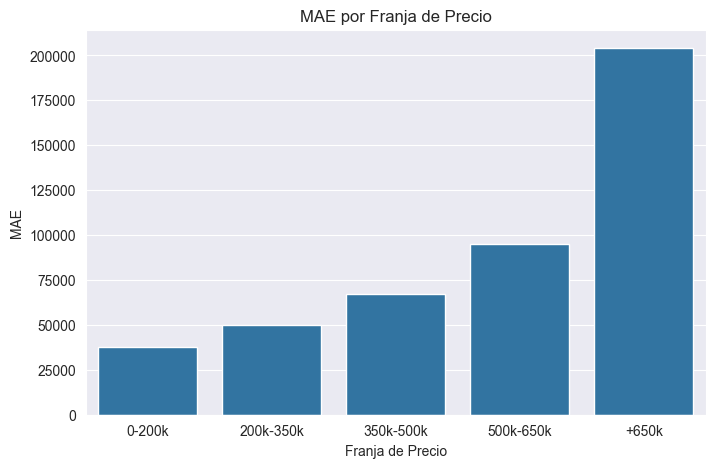

In [8]:
results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_ridge
})

bins = [0, 200000, 350000, 500000, 650000, np.inf]
labels = ['0-200k', '200k-350k', '350k-500k', '500k-650k', '+650k']
results['price_range'] = pd.cut(results['actual'], bins=bins, labels=labels, right=False)

metrics_by_range = results.groupby('price_range', observed=False).apply(
    lambda x: pd.Series({
        'MAE': mean_absolute_error(x['actual'], x['predicted']),
        'MAPE': mean_absolute_percentage_error(x['actual'], x['predicted']),
        'Count': x.size
    }),
    include_groups=False
)

metrics_by_range_df = metrics_by_range.reset_index()
print(metrics_by_range_df)

plt.figure(figsize=(8, 5))
sns.barplot(x='price_range', y='MAE', data=metrics_by_range_df)
plt.title('MAE por Franja de Precio')
plt.xlabel('Franja de Precio')
plt.ylabel('MAE')
plt.show()

Algo un poco alarmante es que en autos de hasta 200k rupias, el error absoluto porcentual medio es bastante alto, de un 33%, luego se mantiene estable para el resto de rangos.

-------------------
#### Regression Tree

-------------------

Veamos primero un arbol de regresión sin restricción de profundidad, y luego busquemos hiperparámetros con optuna:

In [9]:
regression_tree = DecisionTreeRegressor(criterion='squared_error', splitter='best',
                                   max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                   random_state=42)
regression_tree.fit(X_train_processed, y_train_log)

num_leaves = regression_tree.tree_.n_leaves
print(f"Número de hojas del árbol: {num_leaves}")

Número de hojas del árbol: 4423


In [10]:
y_pred_regression_tree_log = regression_tree.predict(X_test_processed)
y_pred_regression_tree = np.expm1(y_pred_regression_tree_log)

y_pred_regression_tree_train_log = regression_tree.predict(X_train_processed)
y_pred_regression_tree_train = np.expm1(y_pred_regression_tree_train_log)

metrics_regression_tree = {
    "name": "Regression_Tree",
    "MAE_training": mean_absolute_error(y_train, y_pred_regression_tree_train), #
    "MAE": mean_absolute_error(y_test, y_pred_regression_tree),
    "RMSE": root_mean_squared_error(y_test, y_pred_regression_tree),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_regression_tree),
    "R2": r2_score(y_test, y_pred_regression_tree)
}
metrics_regression_tree

{'name': 'Regression_Tree',
 'MAE_training': 2683.64568340517,
 'MAE': 91346.34819152587,
 'RMSE': 180713.31323086226,
 'MAPE': 0.21272137700844243,
 'R2': 0.858914356627476}

A pesar de que el modelo parece sufrir de overfitting por el bajo error absoluto medio de entrenamiento, ha mejorado con respecto al error absoluto medio de prueba y el R2.
Veamos si podemos mejorarlo usando random search de hiperparámetros: 

In [11]:
model_file_path = '../models/best_regression_tree_model.pkl'

# Verificar si el modelo ya existe
if os.path.exists(model_file_path):
    print(f"El modelo existe. Cargando el modelo desde '{model_file_path}'...")
    regression_tree_best_model = joblib.load(model_file_path)
    # Acceder a los parámetros del modelo
    max_depth = regression_tree_best_model.max_depth
    min_samples_split = regression_tree_best_model.min_samples_split
    min_samples_leaf = regression_tree_best_model.min_samples_leaf
    max_features = regression_tree_best_model.max_features
    criterion = regression_tree_best_model.criterion
    ccp_alpha = regression_tree_best_model.ccp_alpha

    # Imprimir los valores de los parámetros
    print(f"max_depth: {max_depth}")
    print(f"min_samples_split: {min_samples_split}")
    print(f"min_samples_leaf: {min_samples_leaf}")
    print(f"max_features: {max_features}")
    print(f"criterion: {criterion}")
    print(f"ccp_alpha: {ccp_alpha}")
else:
    # Si no existe, entrenar y guardar el modelo
    print("El modelo no existe. Entrenando un nuevo modelo...")

    param_distributions = {
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
        'splitter': ['best', 'random'],
        'max_depth': [None],
        'min_samples_split': np.arange(2, 4),
        'min_samples_leaf': np.arange(1, 2),
        'max_features': [None, 'sqrt', 'log2'],
        'ccp_alpha': np.linspace(0, 0.0005, 100),
    }
    
    regression_tree = DecisionTreeRegressor()
    random_search = RandomizedSearchCV(
        regression_tree,
        param_distributions,
        n_iter=300,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    
    random_search.fit(X_train_processed, y_train_log)
    
    print("Mejores hiperparámetros: ", random_search.best_params_)    
    regression_tree_best_model = random_search.best_estimator_

    # Guardar el mejor modelo
    joblib.dump(regression_tree_best_model, model_file_path)
    print(f"Nuevo modelo entrenado y guardado como '{model_file_path}'.")

El modelo existe. Cargando el modelo desde '../models/best_regression_tree_model.pkl'...
max_depth: None
min_samples_split: 3
min_samples_leaf: 1
max_features: None
criterion: absolute_error
ccp_alpha: 0.0001414141414141414


In [12]:
num_leaves = regression_tree_best_model.tree_.n_leaves
print(f"Número de hojas del árbol: {num_leaves}")

Número de hojas del árbol: 292


In [13]:
y_pred_regression_tree_log = regression_tree_best_model.predict(X_test_processed)
y_pred_regression_tree = np.expm1(y_pred_regression_tree_log)

y_pred_regression_tree_train_log = regression_tree_best_model.predict(X_train_processed)
y_pred_regression_tree_train = np.expm1(y_pred_regression_tree_train_log)

metrics_regression_tree = {
    "name": "Regression_Tree",
    "MAE_training": mean_absolute_error(y_train, y_pred_regression_tree_train), #
    "MAE": mean_absolute_error(y_test, y_pred_regression_tree),
    "RMSE": root_mean_squared_error(y_test, y_pred_regression_tree),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_regression_tree),
    "R2": r2_score(y_test, y_pred_regression_tree)
}
metrics_regression_tree

{'name': 'Regression_Tree',
 'MAE_training': 61448.518358085836,
 'MAE': 87782.5046406266,
 'RMSE': 190997.23830213284,
 'MAPE': 0.19999538073779977,
 'R2': 0.8423998227901136}

Vemos que logramos mejorar el MAE, y el MAE de entrenamiento quedó cercano al MAE de prueba. No logramos mejorar el R2, incluso empeoró un poco, pero quedó un arbol mucho más simple, de solo 292 hojas.

-------------------
#### Support Vector Regression

-------------------
Para este modelo, vamos a utilizar búsqueda bayesiana de hiperparámetros

In [14]:
model_file_path = '../models/best_svr_model.pkl'

# Verificar si el modelo ya existe
if os.path.exists(model_file_path):
    print(f"El modelo existe. Cargando el modelo desde '{model_file_path}'...")
    svr_best_model = joblib.load(model_file_path)
    # Acceder a los parámetros del modelo
    C = svr_best_model.C
    epsilon = svr_best_model.epsilon
    kernel = svr_best_model.kernel
    degree = svr_best_model.degree if svr_best_model.kernel == 'poly' else None
    gamma = svr_best_model.gamma if svr_best_model.kernel in ['rbf', 'sigmoid'] else None
    coef0 = svr_best_model.coef0 if svr_best_model.kernel == 'poly' else None

    # Imprimir los valores de los parámetros
    print(f"C: {C}")
    print(f"epsilon: {epsilon}")
    print(f"kernel: {kernel}")
    if degree is not None:
        print(f"degree: {degree}")
    if gamma is not None:
        print(f"gamma: {gamma}")
    if coef0 is not None:
        print(f"coef0: {coef0}")
else:
    # Si no existe, entrenar y guardar el modelo
    print("El modelo no existe. Entrenando un nuevo modelo...")

    svm_hitters = SVR()
    
    param_space = {
        'C': (0.01, 100.0, 'log-uniform'),
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': (0.001, 10.0, 'log-uniform'),
        'degree': (2, 6)  # Solo aplicable a kernels polinómicos
    }
    
    bayes_search = BayesSearchCV(
        estimator=svm_hitters,
        search_spaces=param_space,
        n_iter=50, # Número de iteraciones
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42
    )
    
    bayes_search.fit(X_train_processed, y_train_log)
    
    print("Mejores hiperparámetros: ", bayes_search.best_params_)
    
    svr_best_model = bayes_search.best_estimator_    

    # Guardar el mejor modelo
    joblib.dump(svr_best_model, model_file_path)
    print(f"Nuevo modelo entrenado y guardado como '{model_file_path}'.")

El modelo existe. Cargando el modelo desde '../models/best_svr_model.pkl'...
C: 4.700205855276476
epsilon: 0.1
kernel: rbf
gamma: 0.013596358648128583


In [15]:
y_pred_svr_log = svr_best_model.predict(X_test_processed)
y_pred_svr = np.expm1(y_pred_svr_log)

y_pred_svr_train_log = svr_best_model.predict(X_train_processed)
y_pred_svr_train = np.expm1(y_pred_svr_train_log)

metrics_svr = {
    "name": "SVR",
    "MAE_training": mean_absolute_error(y_train, y_pred_svr_train), #
    "MAE": mean_absolute_error(y_test, y_pred_svr),
    "RMSE": root_mean_squared_error(y_test, y_pred_svr),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_svr),
    "R2": r2_score(y_test, y_pred_svr)
}
metrics_svr

{'name': 'SVR',
 'MAE_training': 67124.60745756635,
 'MAE': 76294.9151745797,
 'RMSE': 156329.89139052865,
 'MAPE': 0.17075296249500438,
 'R2': 0.8944188037124718}

Podemos observar que el modelo da por lo pronto el mejor MAE obtenido, además que da un error medio similar para el set de entrenamiento y de prueba. Dentro de los parámetros, vemos que fue elegido un kernel radial (por tanto, se puede ignorar el parámetro de grado).  

-------------------
#### Random Forest

-------------------

Dado que anteriormente la búsqueda de hiperparámetros sirvió para no solo simplificar el árbol sino también para mejorar el MAE y MAE de entrenamiento haremos directamente lo mismo para random forest. 

In [16]:
model_file_path = '../models/best_random_forest_model.pkl'

# Verificar si el modelo ya existe
if os.path.exists(model_file_path):
    print(f"El modelo existe. Cargando el modelo desde '{model_file_path}'...")
    random_forest_best_model = joblib.load(model_file_path)
else:
    # Si no existe, entrenar y guardar el modelo
    print("El modelo no existe. Entrenando un nuevo modelo...")

    model = RandomForestRegressor(random_state=42)

    # Definir el espacio de parámetros
    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': [10, 20, None],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 10),
        'bootstrap': [True, False]
    }

    # Configurar la búsqueda aleatoria con validación cruzada
    random_forest = RandomizedSearchCV(
        estimator=model,
        n_iter=50,
        param_distributions=param_dist,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    random_forest.fit(X_train_processed, y_train_log)

    # Guardar el mejor modelo
    random_forest_best_model = random_forest.best_estimator_
    joblib.dump(random_forest_best_model, model_file_path)
    print(f"Nuevo modelo entrenado y guardado como '{model_file_path}'.")

El modelo existe. Cargando el modelo desde '../models/best_random_forest_model.pkl'...


In [17]:
y_pred_random_forest_log = random_forest_best_model.predict(X_test_processed)
y_pred_random_forest = np.expm1(y_pred_random_forest_log)

y_pred_random_forest_train_log = random_forest_best_model.predict(X_train_processed)
y_pred_random_forest_train = np.expm1(y_pred_random_forest_train_log)

metrics_random_forest = {
    "name": "Random Forest",
    "MAE_training": mean_absolute_error(y_train, y_pred_random_forest_train), #
    "MAE": mean_absolute_error(y_test, y_pred_random_forest),
    "RMSE": root_mean_squared_error(y_test, y_pred_random_forest),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_random_forest),
    "R2": r2_score(y_test, y_pred_random_forest)
}
metrics_random_forest

{'name': 'Random Forest',
 'MAE_training': 42179.6278734451,
 'MAE': 72707.0337414074,
 'RMSE': 146959.98765502084,
 'MAPE': 0.16573401571727514,
 'R2': 0.9066958974877896}

Vemos que por ahora es el mejor modelo no solo por el MAE sino también por el R2. Sin embargo notamos algunas observaciones:

Si bien la diferencia entre el MAE de entrenamiento y de prueba es menor que los anteriores modelos este sigue siendo alto lo cuál sugiere que el modelo sigue sobreajustando.

El RMSE penaliza más los errores grandes que el MAE debido a la cuadratura de los errores. Al ser alto sugiere que algunos puntos de datos están generando errores significativos producto de outliers. 

El R2 del 0.9 muestra un buen poder predictivo general, puede explicar el 91% de la variabilidad. 

-------------------
#### CatBoost

-------------------

Ahora implementaremos dos modelos basados en Boosting: CatBoost y XGBoost

In [18]:
model_file_path = '../models/best_catboost_model.pkl'

# Verificar si el modelo ya existe
if os.path.exists(model_file_path):
    print(f"El modelo existe. Cargando el modelo desde '{model_file_path}'...")
    catboost_best_model = joblib.load(model_file_path)
else:
    # Si no existe, entrenar y guardar el modelo
    print("El modelo no existe. Entrenando un nuevo modelo...")

    model = CatBoostRegressor(
        eval_metric='RMSE',
        random_seed=42,
        verbose=0
    )
    
    params = {
        'iterations': [500, 1000, 1500],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7],
        'bagging_temperature': [0, 0.5, 1]
    }
    
    catboost = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=50,
        scoring='neg_root_mean_squared_error',
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    catboost.fit(X_train_processed, y_train_log)

    # Guardar el mejor modelo
    catboost_best_model = catboost.best_estimator_
    joblib.dump(catboost_best_model, model_file_path)
    print(f"Nuevo modelo entrenado y guardado como '{model_file_path}'.")

El modelo existe. Cargando el modelo desde '../models/best_catboost_model.pkl'...


In [19]:
y_pred_catboost_log = catboost_best_model.predict(X_test_processed)
y_pred_catboost = np.expm1(y_pred_catboost_log)

y_pred_catboost_train_log = catboost_best_model.predict(X_train_processed)
y_pred_catboost_train = np.expm1(y_pred_catboost_train_log)

metrics_catboost = {
    "name": "CatBoost",
    "MAE_training": mean_absolute_error(y_train, y_pred_catboost_train), #
    "MAE": mean_absolute_error(y_test, y_pred_catboost),
    "RMSE": root_mean_squared_error(y_test, y_pred_catboost),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_catboost),
    "R2": r2_score(y_test, y_pred_catboost)
}
metrics_catboost

{'name': 'CatBoost',
 'MAE_training': 55583.6991524622,
 'MAE': 71159.63318441555,
 'RMSE': 149917.77777146202,
 'MAPE': 0.15738176500130827,
 'R2': 0.9029023322938037}

Si bien los resultados en términos generales son mejores que Random Forest y por lo tanto los modelos anteriores, las diferencias (sobre todo con el anterior) no parecen ser significativas:

- Menor MAPE: aunque es marginal parecería ser más precisa


- Menor diferencia entre MAE de entrenamiento y MAE de pruebas: Aquí es dónde vemos algo relevante, entendemos que tiene un ajuste más consistente que Random Forest.  

-------------------
#### XGBoost

-------------------

Seguimos con otra implementación de modelos basados en Boosting:

In [20]:
model_file_path = '../models/best_xgboost_model.pkl'

# Verificar si el modelo ya existe
if os.path.exists(model_file_path):
    print(f"El modelo existe. Cargando el modelo desde '{model_file_path}'...")
    xgb_best_model = joblib.load(model_file_path)
else:
    # Si no existe, entrenar y guardar el modelo
    print("El modelo no existe. Entrenando un nuevo modelo...")

    model = XGBRegressor(random_state=42)
    
    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 0.5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(1, 2)
    }
    
    xgb = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=50,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring='neg_mean_squared_error',
        random_state=42,
    )
    
    xgb.fit(X_train_processed, y_train_log)    

    # Guardar el mejor modelo
    xgb_best_model = xgb.best_estimator_
    joblib.dump(xgb_best_model, model_file_path)
    print(f"Nuevo modelo entrenado y guardado como '{model_file_path}'.")

El modelo existe. Cargando el modelo desde '../models/best_xgboost_model.pkl'...


/Users/cbarril/posgrado/materias/aprendizaje_maquinas_I/tp_amq1_17co2024/amq1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:13:25] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [21]:
y_pred_xgboost_log = xgb_best_model.predict(X_test_processed)
y_pred_xgboost = np.expm1(y_pred_xgboost_log)

y_pred_xgboost_train_log = xgb_best_model.predict(X_train_processed)
y_pred_xgboost_train = np.expm1(y_pred_xgboost_train_log)

metrics_xgboost = {
    "name": "XGBoost",
    "MAE_training": mean_absolute_error(y_train, y_pred_xgboost_train), #
    "MAE": mean_absolute_error(y_test, y_pred_xgboost),
    "RMSE": root_mean_squared_error(y_test, y_pred_xgboost),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_xgboost),
    "R2": r2_score(y_test, y_pred_xgboost)
}
metrics_xgboost

{'name': 'XGBoost',
 'MAE_training': 56972.30086585318,
 'MAE': 71598.03938018829,
 'RMSE': 153503.78497454323,
 'MAPE': 0.15773567557166537,
 'R2': 0.8982016444206238}

Vemos que ambos modelos (XGBoost y CatBoost) tienen métricas casi idénticas, lo que se indicó en CatBoost también se podría decir para XGBoost 

-------------------
#### Neural Network

-------------------

In [22]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X, y_log, test_size=0.3, random_state=42)
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_nn, y_train_nn, test_size=0.3, random_state=42)

X_train_processed_nn = final_pipeline.fit_transform_df(X_train_nn)
X_test_processed_nn = final_pipeline.transform_df(X_test_nn)
X_val_processed_nn = final_pipeline.transform_df(X_val_nn)

X_train_tensor = torch.tensor(X_train_processed_nn.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed_nn.to_numpy(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_processed_nn.to_numpy(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_nn.to_numpy(), dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_nn.to_numpy(), dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val_nn.to_numpy(), dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

/Users/cbarril/posgrado/materias/aprendizaje_maquinas_I/tp_amq1_17co2024/amq1/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/cbarril/posgrado/materias/aprendizaje_maquinas_I/tp_amq1_17co2024/amq1/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [23]:
input_dim = X_train_processed_nn.shape[1]
nn = UsedCarQuoteNN(input_size=input_dim)

optimizer = torch.optim.Adam(nn.parameters(), lr=0.001)
loss_fn = torch.nn.HuberLoss()

nn.fit(train_loader=train_loader, test_loader=val_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=140)

In [24]:
nn.eval()

y_pred_log_list = []
y_test_log_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred_nn = nn(X_batch)
        y_pred_log_list.append(y_pred_nn.numpy())
        y_test_log_list.append(y_batch.numpy())

In [25]:
y_pred_log_np = np.vstack(y_pred_log_list)
y_test_log_np = np.vstack(y_test_log_list)

y_pred_np = np.expm1(y_pred_log_np)
y_test_np = np.expm1(y_test_log_np)

metrics_nn = {
    "name": "NN",
    "MAE": mean_absolute_error(y_test_np, y_pred_np),
    "RMSE": root_mean_squared_error(y_test_np, y_pred_np),
    "MAPE": mean_absolute_percentage_error(y_test_np, y_pred_np),
    "R2": r2_score(y_test_np, y_pred_np)
}
metrics_nn

{'name': 'NN',
 'MAE': 96316.11,
 'RMSE': 221474.86,
 'MAPE': 0.19741464,
 'R2': 0.7880899906158447}

En líneas generales la red neuronal performó peor que los modelos anteriores: 

- El alto MAE indica que las predicciones promedio están menos ajustadas y sugiere que la red alcanzó un buen punto de generalización.


- El alto MAPE indica que la red neuronal tiene más dificultad en capturar las variaciones relativas de los precios.


- El alto RMSE sugiere que la red neuronal tiene más problemas con los outliers o datos atípicos.

Creemos que estos problemas pueden darse por dos motivos: 

- Dataset relativamente chico: Entendemos que las redes neuronales son muy poderosas a la hora de captar relaciones no lineales entre las features pero requieren de un gran número de datos para hacerlo. Pensamos que el número de observaciones es insuficiente para captarlas en su totalidad.


- Arquitectura y parámetros no optimizados: Nos falta entendimiento de las estructuras de las redes neuronales y su funcionamiento, su pobre desempeño quizás esté relacionado con su construcción simplista. 


Por todos estos motivos excluirémos la red de la sección de comparación de modelos ya que entendemos no suma demasiado o incluso puede entorpecer el análisis

-------------------
#### Models Comparison

-------------------

In [26]:
metrics = pd.DataFrame([metrics_ridge, metrics_regression_tree, metrics_svr, metrics_random_forest, metrics_catboost, metrics_xgboost, metrics_nn],)
metrics.sort_values(by=['MAE'], ascending=True)

,name,MAE_training,MAE,RMSE,MAPE,R2
4,CatBoost,55583.699152,71159.633184,149917.777771,0.157382,0.902902
5,XGBoost,56972.300866,71598.039380,153503.784975,0.157736,0.898202
3,Random Forest,42179.627873,72707.033741,146959.987655,0.165734,0.906696
2,SVR,67124.607458,76294.915175,156329.891391,0.170753,0.894419
1,Regression_Tree,61448.518358,87782.504641,190997.238302,0.199995,0.842400
0,Ridge,95959.082043,94858.948041,190214.867635,0.204167,0.843688
6,NN,NaN,96316.109375,221474.859375,0.197415,0.788090


Aunque todos los modelos muestran un rendimiento similar, Ridge es el que presenta el peor desempeño. Esto se debe a su naturaleza lineal: si bien el dataset contiene variables con alta correlación, también incluye interacciones complejas que Ridge no parece capturar de manera efectiva.

Es comprensible que modelos más simples, como los árboles de decisión o las regresiones lineales, obtengan resultados inferiores frente a algoritmos más sofisticados como CatBoost. Este último, al ser un método de boosting optimizado para manejar variables categóricas, destaca en su capacidad para capturar relaciones no lineales y gestionar datos de alta dimensionalidad, lo que explica su superioridad respecto al resto.

Por otro lado, aunque las redes neuronales tienen potencial para lograr un rendimiento comparable al de los modelos basados en boosting, su desempeño en este caso no fue el esperado. Esto probablemente se deba a que aún necesitamos profundizar en la construcción y ajuste de su arquitectura para explotar todo su potencial.

La elección del modelo ideal no es una tarea sencilla y depende en gran medida del contexto de aplicación. Por ejemplo, si priorizamos la consistencia en las predicciones, CatBoost o XGBoost serían las opciones más adecuadas. En cambio, si buscamos maximizar el R², aunque con mayor riesgo de overfitting, Random Forest podría ser la opción más conveniente.

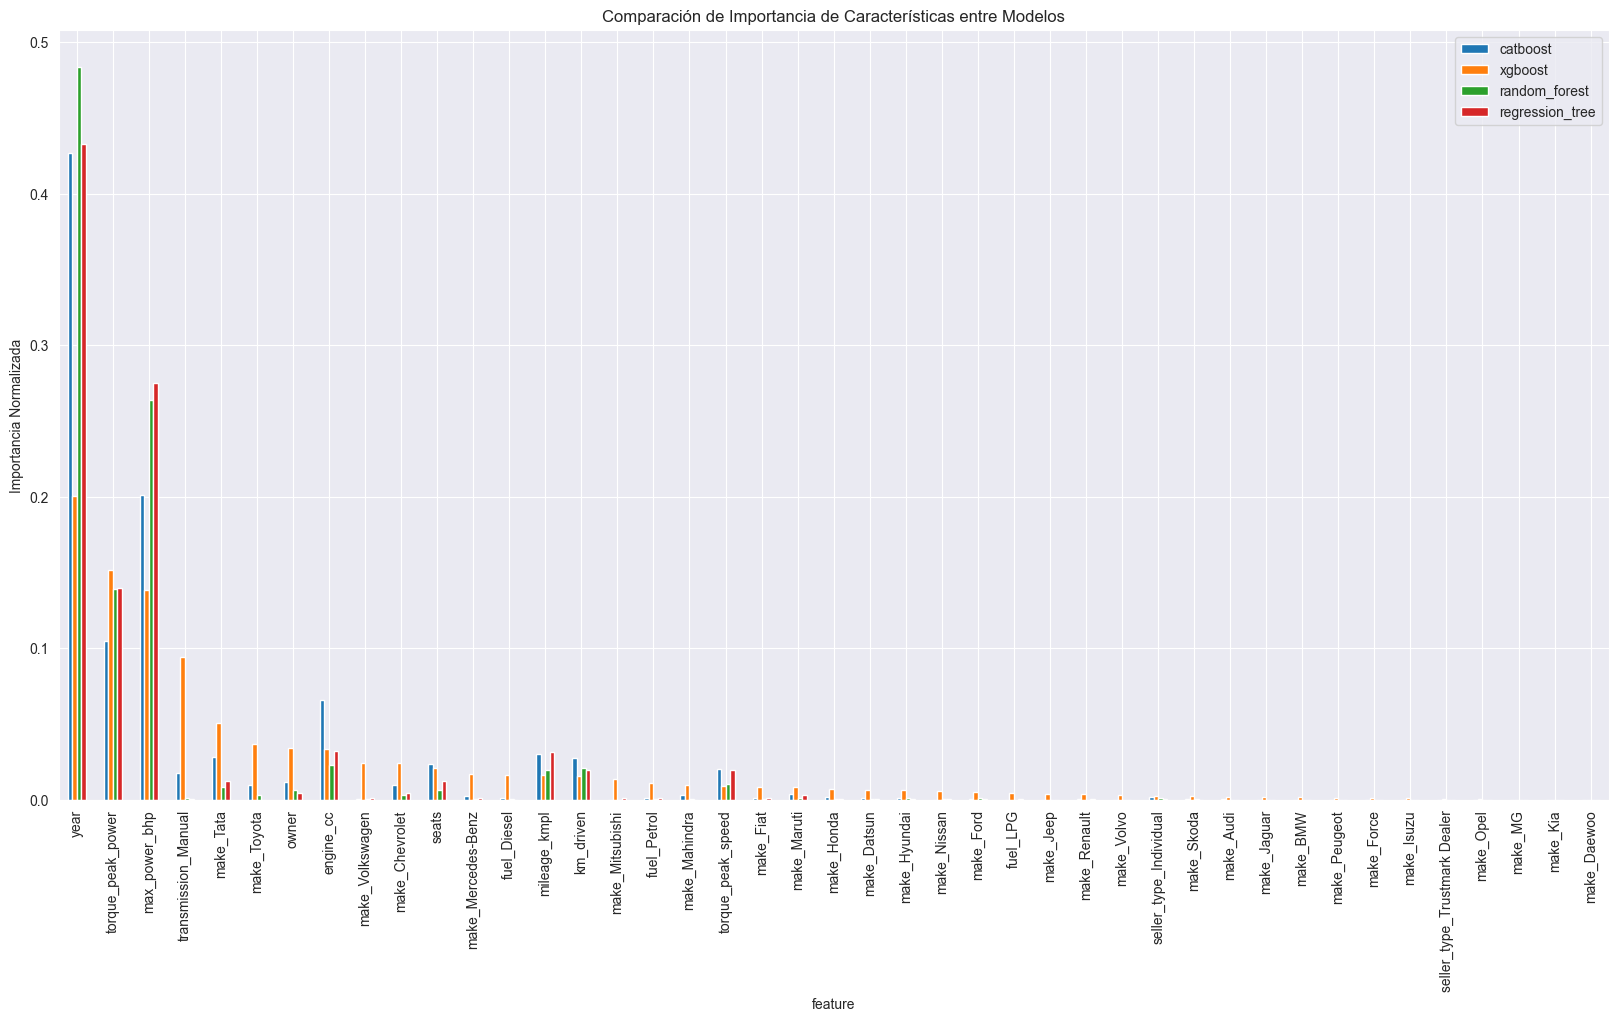

In [27]:
catboost_importances = catboost_best_model.get_feature_importance()
xgboost_importances = xgb_best_model.feature_importances_
rf_importances = random_forest_best_model.feature_importances_
rt_importances = regression_tree_best_model.feature_importances_

features = X_train_processed.columns
importance_df = pd.DataFrame({
    'feature': features,
    'catboost': catboost_importances,
    'xgboost': xgboost_importances,
    'random_forest': rf_importances,
    'regression_tree': rt_importances,
})

importance_df['catboost'] /= importance_df['catboost'].sum()
importance_df['xgboost'] /= importance_df['xgboost'].sum()
importance_df['random_forest'] /= importance_df['random_forest'].sum()
importance_df['regression_tree'] /= importance_df['regression_tree'].sum()

importance_df = importance_df.sort_values(by='xgboost', ascending=False)

importance_df.plot(x='feature', kind='bar', figsize=(20, 10),
                   title="Comparación de Importancia de Características entre Modelos")
plt.xticks(rotation=90)
plt.ylabel("Importancia Normalizada")
plt.show()

Este gráfico ilustra las dimensiones más relevantes según los modelos basados en árboles. 

Un aspecto llamativo es que **XGBoost** es el único modelo que distribuye los pesos de manera más equilibrada, mientras que los demás tienden a concentrar la importancia en unas pocas dimensiones específicas. 

Además, se observa una **coherencia general en las dimensiones destacadas** por todos los modelos, lo que sugiere que identifican patrones similares en los datos.

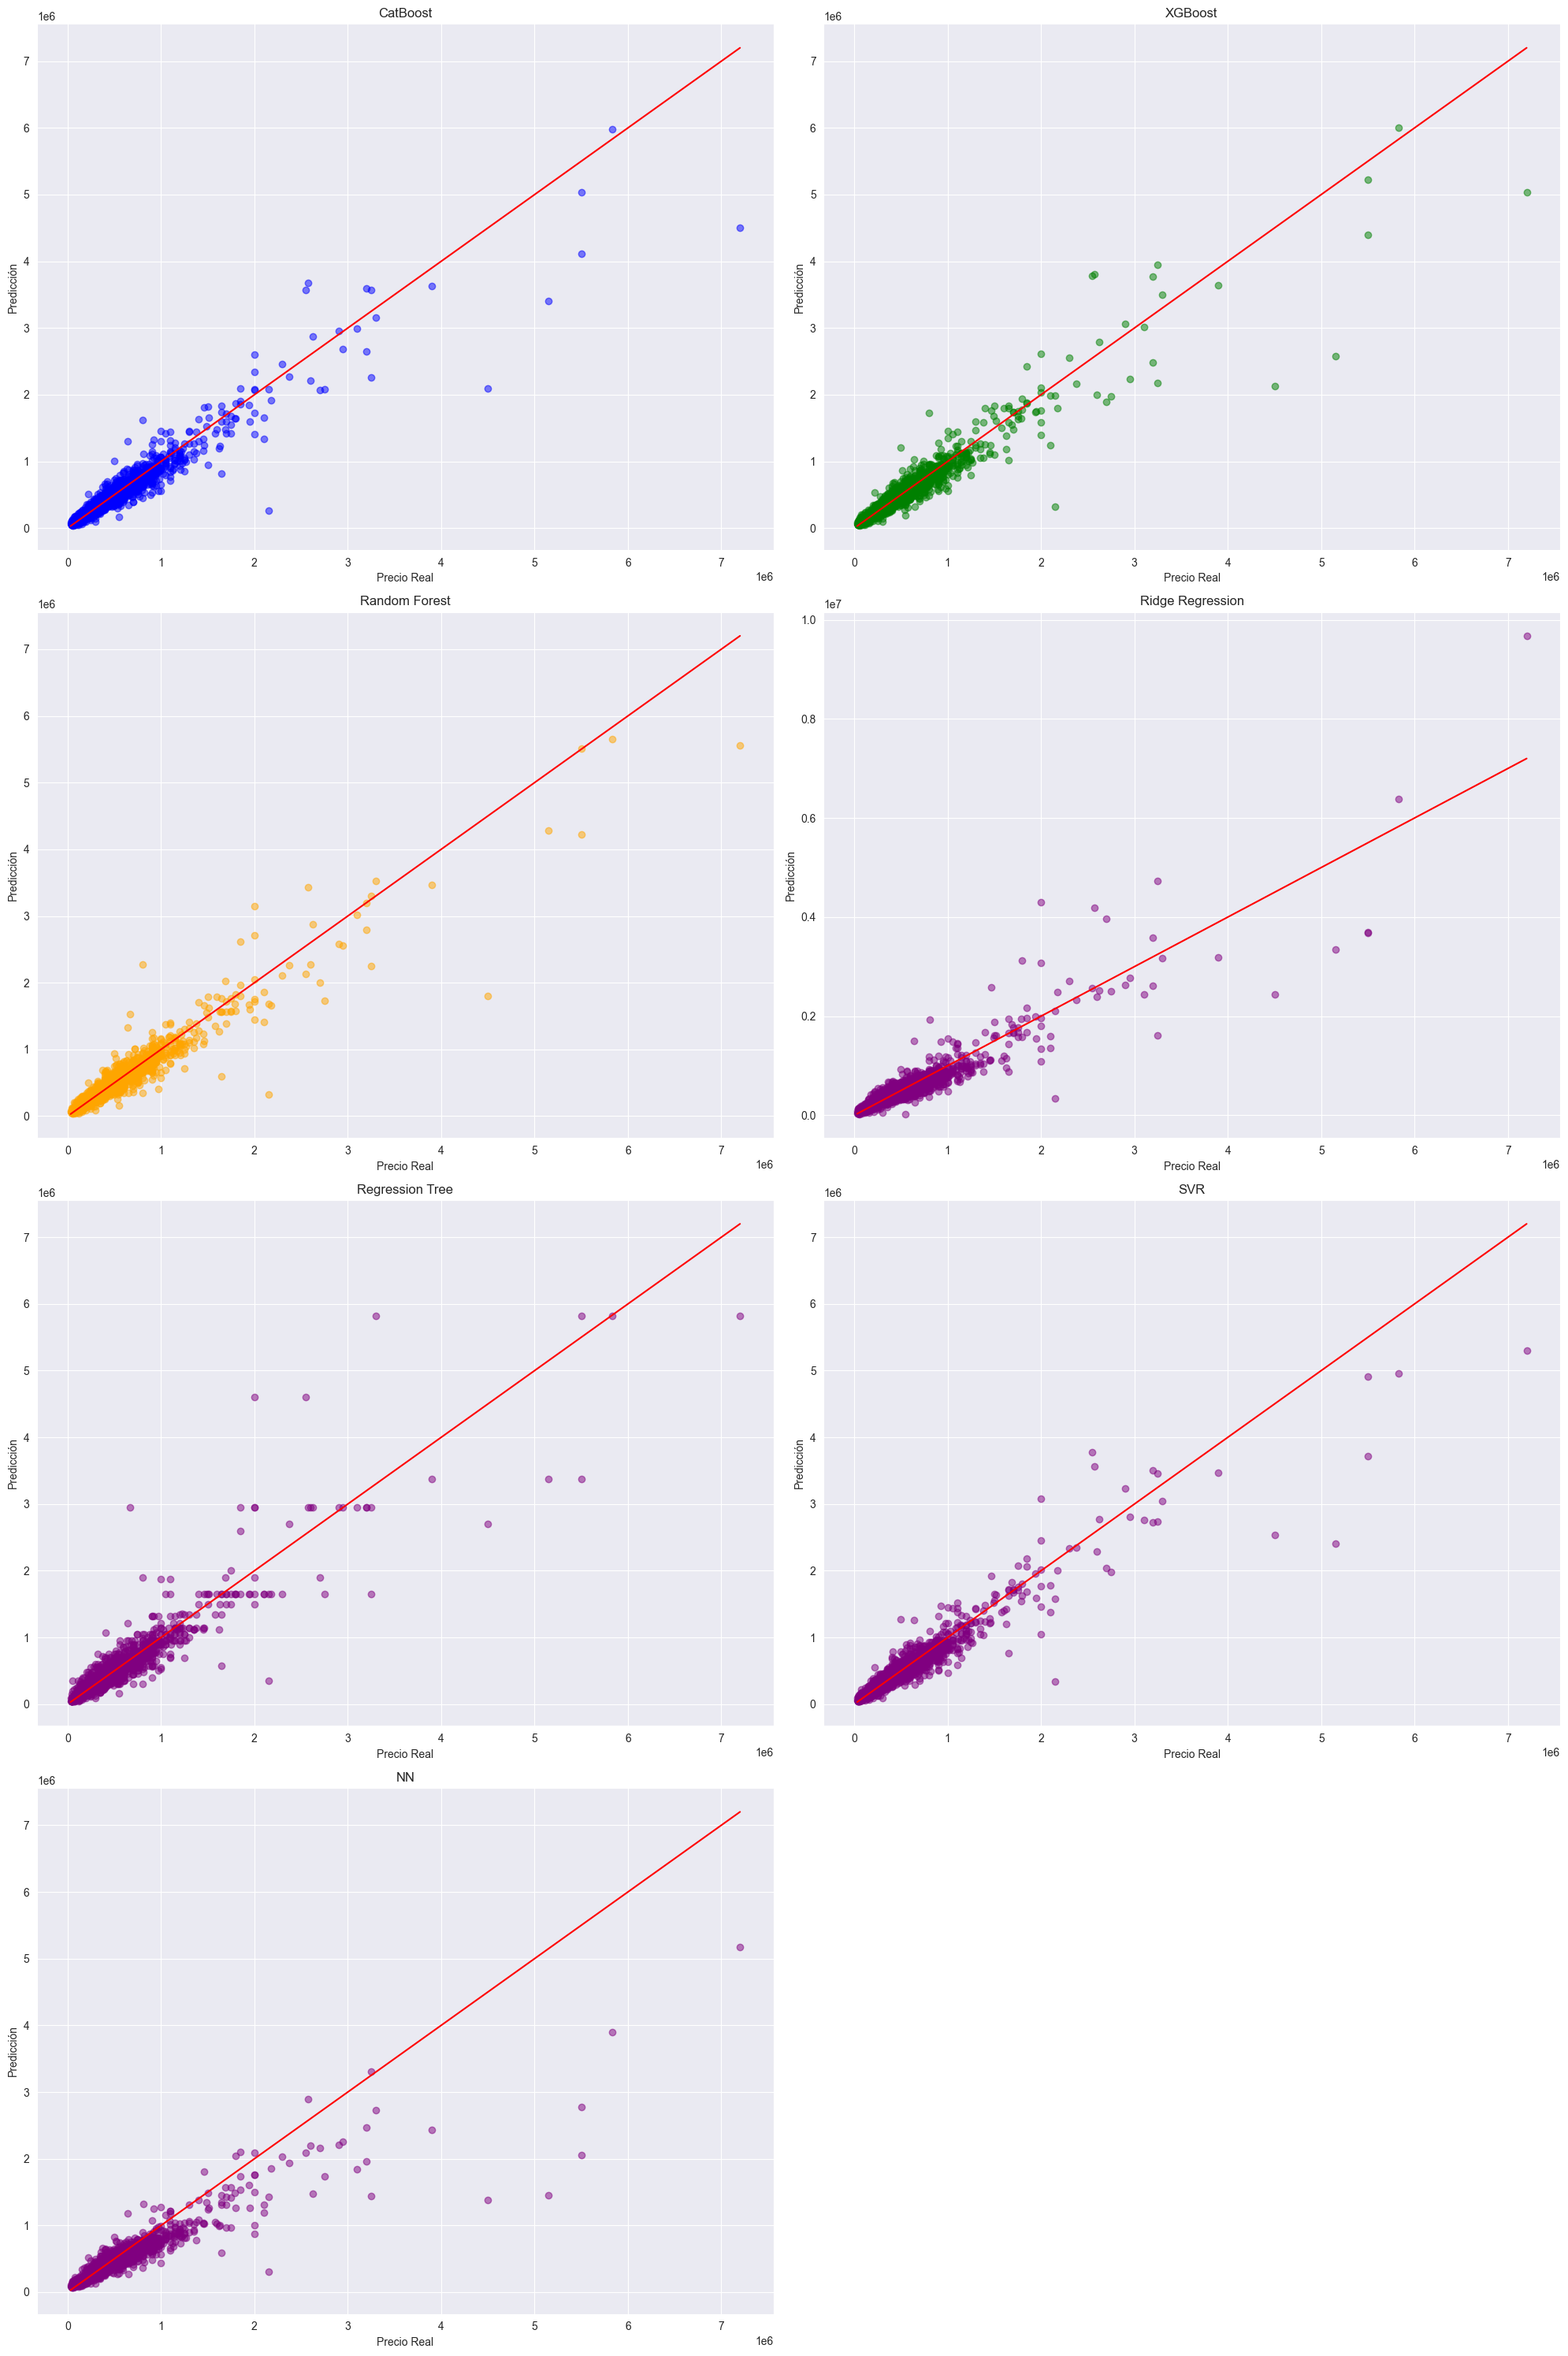

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 30))

# Gráfico 1: CatBoost
plt.subplot(4, 2, 1)
plt.scatter(y_test, y_pred_catboost, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("CatBoost")
plt.xlabel("Precio Real")
plt.ylabel("Predicción")

# Gráfico 2: XGBoost
plt.subplot(4, 2, 2)
plt.scatter(y_test, y_pred_xgboost, alpha=0.5, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("XGBoost")
plt.xlabel("Precio Real")
plt.ylabel("Predicción")

# Gráfico 3: Random Forest
plt.subplot(4, 2, 3)
plt.scatter(y_test, y_pred_random_forest, alpha=0.5, color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("Random Forest")
plt.xlabel("Precio Real")
plt.ylabel("Predicción")

# Gráfico 4: Ridge
plt.subplot(4, 2, 4)
plt.scatter(y_test, y_pred_ridge, alpha=0.5, color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("Ridge Regression")
plt.xlabel("Precio Real")
plt.ylabel("Predicción")

# Gráfico 5: Regression Tree
plt.subplot(4, 2, 5)
plt.scatter(y_test, y_pred_regression_tree, alpha=0.5, color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("Regression Tree")
plt.xlabel("Precio Real")
plt.ylabel("Predicción")

# Gráfico 6: SVR
plt.subplot(4, 2, 6)
plt.scatter(y_test, y_pred_svr, alpha=0.5, color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("SVR")
plt.xlabel("Precio Real")
plt.ylabel("Predicción")

# Gráfico 7: NN
plt.subplot(4, 2, 7)
plt.scatter(y_test_np, y_pred_np, alpha=0.5, color='purple')
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red')
plt.title("NN")
plt.xlabel("Precio Real")
plt.ylabel("Predicción")

# Ajustar diseño para evitar superposición
plt.tight_layout()

# Mostrar gráficos
plt.show()


Los gráficos que vemos muestran que tan precisas son las predicciones de los modelos, la línea roja es una recta que identifica el lugar donde la predicción fue perfecta. 

Se puede ver a simple vista que CatBoost, XGBoost, Random Forest y SVR tienden a subestimar el valor de los autos cuanto más alto es el precio de los mismos. Se puede ver como hay más puntos bajo la línea roja a medida que crece el precio real. 

El resto de los modelos (Regression Tree, Ridge y NN), en cambio, tiene una tendencia a subestimar y sobreestimar por igual.

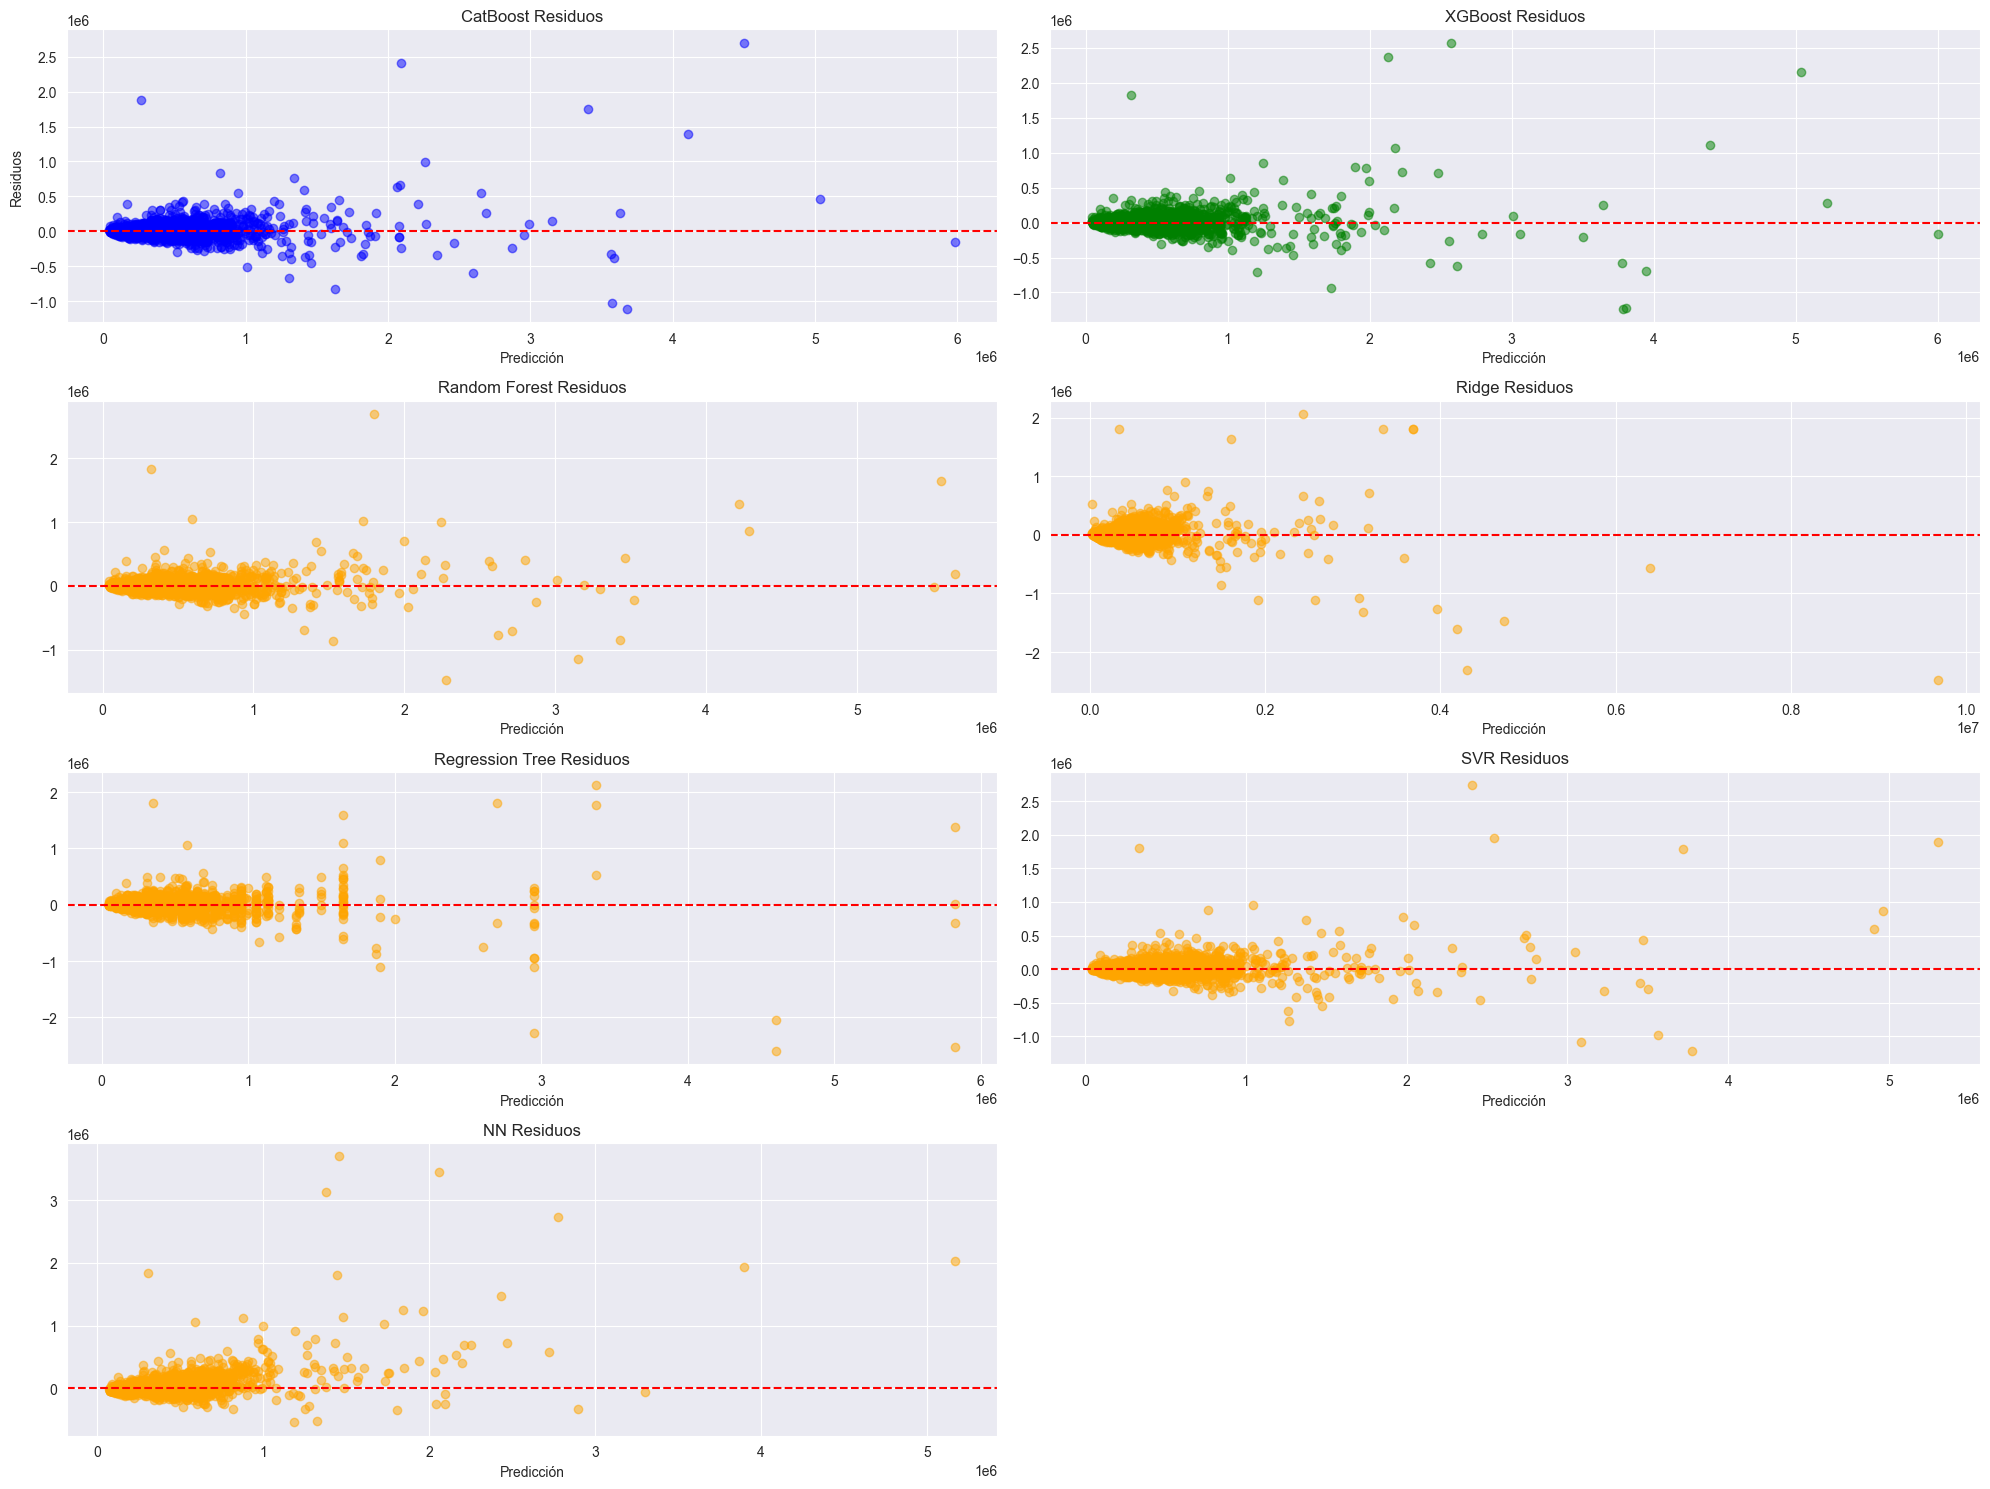

In [29]:
plt.figure(figsize=(20, 15))

plt.subplot(4, 2, 1)
residuals_catboost = y_test - y_pred_catboost
plt.scatter(y_pred_catboost, residuals_catboost, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("CatBoost Residuos")
plt.xlabel("Predicción")
plt.ylabel("Residuos")

plt.subplot(4, 2, 2)
residuals_xgboost = y_test - y_pred_xgboost
plt.scatter(y_pred_xgboost, residuals_xgboost, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("XGBoost Residuos")
plt.xlabel("Predicción")

plt.subplot(4, 2, 3)
residuals_rf = y_test - y_pred_random_forest
plt.scatter(y_pred_random_forest, residuals_rf, alpha=0.5, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Random Forest Residuos")
plt.xlabel("Predicción")

plt.subplot(4, 2, 4)
residuals_rf = y_test - y_pred_ridge
plt.scatter(y_pred_ridge, residuals_rf, alpha=0.5, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Ridge Residuos")
plt.xlabel("Predicción")
plt.tight_layout()

plt.subplot(4, 2, 5)
residuals_rf = y_test - y_pred_regression_tree
plt.scatter(y_pred_regression_tree, residuals_rf, alpha=0.5, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Regression Tree Residuos")
plt.xlabel("Predicción")
plt.tight_layout()

plt.subplot(4, 2, 6)
residuals_rf = y_test - y_pred_svr
plt.scatter(y_pred_svr, residuals_rf, alpha=0.5, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("SVR Residuos")
plt.xlabel("Predicción")
plt.tight_layout()

plt.subplot(4, 2, 7)
residuals_rf = y_test_np - y_pred_np
plt.scatter(y_pred_np, residuals_rf, alpha=0.5, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("NN Residuos")
plt.xlabel("Predicción")
plt.tight_layout()

plt.show()

Repitamos el análisis hecho en Ridge, pero para ahora el resto de modelos, para ver el MAE y el MAPE para distintos rangos de precio. A diferencia de ese gráfico, vamos a partir el último bin en 3, para identificar lo que ocurre con los vehículos de mayor valor, aunque para esos rangos tengamos menos observaciones.

In [30]:
import warnings

# Ignorar advertencias específicas
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

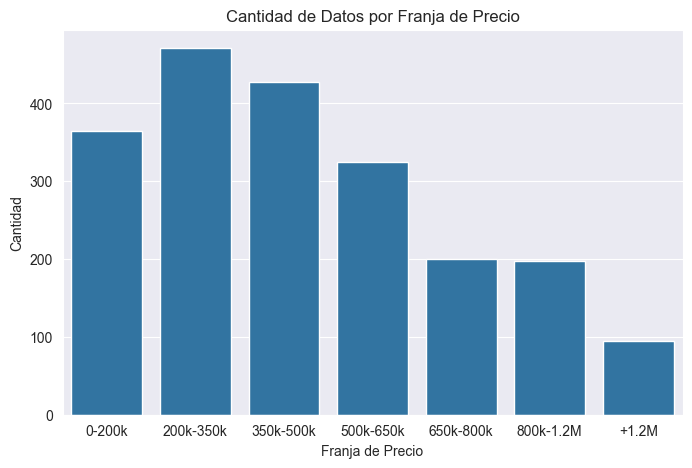

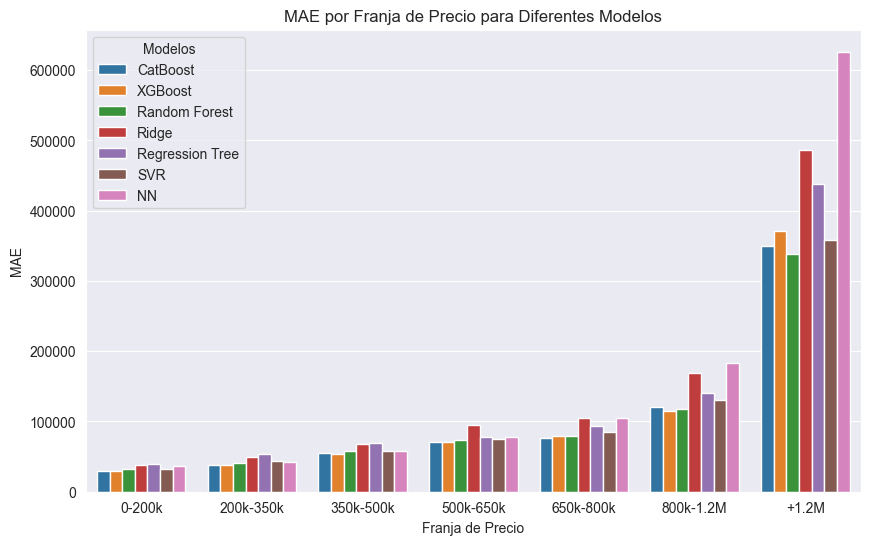

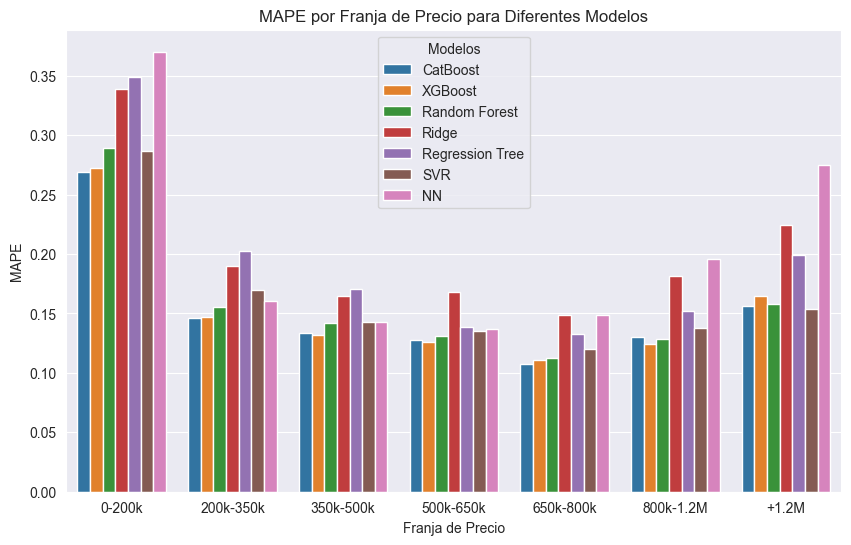

In [31]:
model_predictions = {
    'CatBoost': y_pred_catboost,
    'XGBoost': y_pred_xgboost,
    'Random Forest': y_pred_random_forest,
    'Ridge': y_pred_ridge,
    'Regression Tree': y_pred_regression_tree,
    'SVR': y_pred_svr,
    'NN': y_pred_np,
}

# Definir los bins y etiquetas
bins = [0, 200000, 350000, 500000, 650000, 800000, 1200000, np.inf]
labels = ['0-200k', '200k-350k', '350k-500k', '500k-650k', '650k-800k', '800k-1.2M', '+1.2M']

# DataFrame para almacenar todas las métricas
all_metrics = []

price_ranges = pd.cut(y_test, bins=bins, labels=labels, right=False)
# Contar cuántos valores hay en cada franja de precio
counts_by_range = price_ranges.value_counts().sort_index()
# Mostrar los counts
counts_by_range_df = counts_by_range.reset_index()
counts_by_range_df.columns = ['price_range', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(x='price_range', y='Count', data=counts_by_range_df)
plt.title('Cantidad de Datos por Franja de Precio')
plt.xlabel('Franja de Precio')
plt.ylabel('Cantidad')
plt.show()
y_test = np.ravel(y_test)

# Aplanar cada predicción (y_pred) en el diccionario de predicciones
for model_name, y_pred in model_predictions.items():
    y_pred = np.ravel(y_pred)  # Aplanar la predicción si es necesario

    # Crear el DataFrame de resultados
    results = pd.DataFrame({
        'actual': y_test,
        'predicted': y_pred
    })
    results['price_range'] = pd.cut(results['actual'], bins=bins, labels=labels, right=False)
    
    # Calcular métricas por franja de precio
    metrics_by_range = results.groupby('price_range').apply(
        lambda x: pd.Series({
            'MAE': mean_absolute_error(x['actual'], x['predicted']),
            'MAPE': mean_absolute_percentage_error(x['actual'], x['predicted']),
        })
    )
    
    metrics_by_range['Model'] = model_name
    all_metrics.append(metrics_by_range)

# Convertir lista a DataFrame
metrics_by_range_df = pd.concat(all_metrics).reset_index()

# Gráfico de MAE por franja de precio para cada modelo
plt.figure(figsize=(10, 6))
sns.barplot(x='price_range', y='MAE', hue='Model', data=metrics_by_range_df)
plt.title('MAE por Franja de Precio para Diferentes Modelos')
plt.xlabel('Franja de Precio')
plt.ylabel('MAE')
plt.legend(title='Modelos')
plt.show()

# Gráfico de MAE por franja de precio para cada modelo
plt.figure(figsize=(10, 6))
sns.barplot(x='price_range', y='MAPE', hue='Model', data=metrics_by_range_df)
plt.title('MAPE por Franja de Precio para Diferentes Modelos')
plt.xlabel('Franja de Precio')
plt.ylabel('MAPE')
plt.legend(title='Modelos')
plt.show()

Este gráfico muestra los residuos (diferencia entre los valores reales y los predichos) en función de las predicciones para los cuatro modelos. Así podemos observar qué tan bien los modelos están ajustando los datos en diferentes rangos de predicción.

- A todos los modelos les cuesta predecir a medida que los precios suben. Confirmando lo analizado en los gráficos anteriores.
- CatBoost y XGBoost tienen distribuciones similares, uniformes y cercanas a cero.
- Random Forest logra predecir muy bien valores bajos, pero a medida que los valores crecen se dispersa mucho más que XGBoost y CatBoost
- Ridge tiene la peor distribución de residuos, lo que confirma que no es adecuado para este tipo de problema con relaciones complejas y no lineales.

-------------------
#### Conclusiones

-------------------

CatBoost fue el modelo con mejor desempeño, tal como esperábamos, gracias a su capacidad de manejar eficientemente variables categóricas, que representan una parte importante de nuestro dataset. Esto confirma su adecuación para este tipo de problemas no lineales.


### Limitaciones del modelo

- No podemos confirmar si la precisión de las predicciones es adecuada para cualquier uso del mismo. Por un lado, habría que confirmar que el MAE/MAPE es aceptable para el tipo de predicción que se requiera. Por otro lado, los modelos utilizan el año de operación para predecir los valores dentro del mismo dataset. Es posible que este dato no sea de mucha utilidad si se necesita un modelo para predecir valores de futuras ventas.
- El dataset contiene datos exclusivos de India, por lo que sería arriesgado suponer que puede ser de utilidad para predecir valores de vehículos en otras ubicaciones.
- El dataset no contiene datos posteriores al 2020, siendo el paso del tiempo extremadamente sensible en el precio de los automóviles. Incluso el dataset v4 contiene datos hasta 2022. Esta no es solo una.


### Próximos pasos

- Entrenar el modelo CatBoost con el dataset completo, para desplegarlo productivamente.
- Intentar normalizar los datos del dataset v4 para ajustarlos a este modelo.
- Obtener las features faltantes del dataset v3 (y presentes en el v4) de otras fuentes de información, y volver a hacer ingeniería de features para intentar construir un mejor modelo.
- Explorar alternativas como ajustar valores del dataset según el año de la operación, teniendo en cuenta la devaluación de la moneda India y la inflación. 